# M01. Park and Weather Factors

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Functions.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U4. Datasets.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U5. Models.ipynb"

### Data

##### MLB Stats API

In [2]:
start_year, end_year = 2015, 2025

Merge MLB Stats API and Statcast data

In [3]:
%%time
df = merge_datasets(start_year, end_year)
df = clean_weather(df)
df = create_events(df)
df = create_variables(df)
df = start_data(df)

CPU times: total: 2min 22s
Wall time: 1min 8s


##### Open Meteo

Read in Open Meteo weather data

In [4]:
%%time
weather_df = pd.concat(map(pd.read_csv, glob.glob(r"C:\Users\james\Documents\MLB\Database\A06. Weather\1. Open Meteo\*.csv")), ignore_index=True)[
       ['game_id', 'year', 'venue_name', 'location.defaultCoordinates.latitude', 'location.defaultCoordinates.longitude', 
        'fieldInfo.leftLine', 'fieldInfo.center', 'fieldInfo.rightLine', 'fieldInfo.leftCenter', 'fieldInfo.rightCenter', 
        'location.elevation', 'location.azimuthAngle', 'fieldInfo.roofType', 'active', 
        'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 
        'wind_speed_10m', 'wind_direction_10m', 'weather_code', 'precipitation_probability']]

CPU times: total: 5.25 s
Wall time: 5.63 s


Calculate wind vectors

In [5]:
def calculate_vectors(row, azimuth_column, wind_column, speed_column):
    angle = row[wind_column] - row[azimuth_column]
    
    # Calculate vectors
    x_vect = round(math.sin(math.radians(angle)), 5) * row[speed_column] * -1
    y_vect = round(math.cos(math.radians(angle)), 5) * row[speed_column] * -1

    return pd.Series([x_vect, y_vect], index=['x_vect', 'y_vect'])

In [6]:
weather_df[['meteo_x_vect', 'meteo_y_vect']] = weather_df.apply(lambda row: calculate_vectors(row, 'location.azimuthAngle', 'wind_direction_10m', 'wind_speed_10m'), axis=1)

##### Baserunning

In [7]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1', usecols=['proj_date', 'mlbamid', 'PA', 'UBR'], dtype='str')

Convert data types

In [8]:
steamer_hitters_df[['PA', 'UBR']] = steamer_hitters_df[['PA', 'UBR']].astype(float)

In [9]:
steamer_hitters_df['proj_date'] = pd.to_datetime(steamer_hitters_df['proj_date'])

Calculate UBR per 600 Plate Appearances

In [10]:
steamer_hitters_df['UBR600'] = steamer_hitters_df['UBR'] / steamer_hitters_df['PA'] * 600

##### Merge

Weather data

In [11]:
complete_dataset = df.merge(weather_df.drop(columns=['year']), left_on=['gamePk'], right_on=['game_id'], how='inner')

Use weather column from MLB data to adjust for domes/roofs

In [12]:
mask = complete_dataset['weather'].str.contains('Roof|Dome', case=False, na=False)

In [13]:
complete_dataset.loc[mask, 'temperature'] = 70
complete_dataset.loc[mask, 'x_vect'] = 0
complete_dataset.loc[mask, 'y_vect'] = 0

In [14]:
complete_dataset.loc[mask, 'temperature_2m'] = 70
complete_dataset.loc[mask, 'meteo_x_vect'] = 0
complete_dataset.loc[mask, 'meteo_y_vect'] = 0
complete_dataset.loc[mask, 'relative_humidity_2m'] = 60
complete_dataset.loc[mask, 'dew_point_2m'] = 57

Baserunning Data

In [15]:
complete_dataset['proj_date'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')

In [16]:
complete_dataset['mlbamid'] = complete_dataset['batter'].astype(str)

In [17]:
complete_dataset = pd.merge_asof(
    complete_dataset.sort_values('proj_date'),
    steamer_hitters_df.sort_values('proj_date'),
    by='mlbamid',
    on='proj_date',
    direction='backward'
)

Note:
- if y > 198.27 and x < 125.42), it's actually to left
- if y > 198.27 and x > 125.42), it's actually to right

### Model #1. Expected Outcome

Probability of events given how the baseball was launched, where it was launched to, and some information about the batter, including handedness and base running. Notably excluded park and weather.

$ \hat{\text{eventsModel}} = launch\_angle + launch\_speed + to\_l + to\_lc + to\_c + to\_rc + to\_r + b\_L + UBR600 $

##### Inputs

In [18]:
outcome_inputs = ['launch_angle', 'launch_speed', 'to_l', 'to_lc', 'to_c', 'to_rc', 'to_r', 'b_L', 'UBR600'] + ['bb', 'hbp', 'so']

##### Sample

Sent launch data to 0 if not batted

In [19]:
complete_dataset[['launch_angle', 'launch_speed']] = complete_dataset[['launch_angle', 'launch_speed']].fillna(0)

Remove atypical events and missings

In [20]:
complete_dataset = complete_dataset[~complete_dataset['eventsModel'].isin(["Cut"])].dropna(subset=outcome_inputs)

Define model input and outputs

In [21]:
X = complete_dataset[outcome_inputs].values
y = complete_dataset[['eventsModel']].values

##### Encode

In [22]:
if not hasattr(sys.modules['__main__'], '__file__'): # Run if notebook is origin file
# if 1 == 2: # Force not to run regardless of origin file 
    # One-hot encode the target
    encode_outcome = OneHotEncoder(sparse_output=False)
    # Fit and transform
    y_encoded = encode_outcome.fit_transform(y)
    # Create folder
    os.makedirs(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate), exist_ok=True)   
    # Save
    pickle.dump(encode_outcome, open(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate, "encode_outcome.pkl"), 'wb'))
else:
    y_encoded = encode_outcome.transform(y)

# Calculate number of classes (used for model inputs)
num_classes = y_encoded.shape[1]

##### Scale

In [23]:
if not hasattr(sys.modules['__main__'], '__file__'): # Run if notebook is origin file
# if 1 == 2: # Force not to run regardless of origin file 
    # Scale
    scale_outcome = StandardScaler()
    # Fit and transform
    X_scaled = scale_outcome.fit_transform(X)
    # Save
    pickle.dump(scale_outcome, open(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate, "scale_outcome.pkl"), 'wb'))
else:
    X_scaled = scale_outcome.transform(X)

##### Train

In [24]:
if not hasattr(sys.modules['__main__'], '__file__'): # Run if notebook is origin file
# if 1 == 2: # Force not to run regardless of origin file 
    predict_outcome = Sequential([
        Dense(32, input_shape=(X_scaled.shape[1],), activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  # softmax for multi-class classification
    ])
    
    predict_outcome.compile(optimizer=Adam(learning_rate=0.00001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)
    
    predict_outcome.fit(
        X_scaled, y_encoded,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop])

    predict_outcome.save(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate, 'predict_outcome.keras'))

Epoch 1/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.7009 - loss: 0.9477 - val_accuracy: 0.8275 - val_loss: 0.4779
Epoch 2/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.8228 - loss: 0.4855 - val_accuracy: 0.8349 - val_loss: 0.4460
Epoch 3/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.8288 - loss: 0.4600 - val_accuracy: 0.8377 - val_loss: 0.4333
Epoch 4/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - accuracy: 0.8306 - loss: 0.4505 - val_accuracy: 0.8390 - val_loss: 0.4261
Epoch 5/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - accuracy: 0.8314 - loss: 0.4437 - val_accuracy: 0.8396 - val_loss: 0.4226
Epoch 6/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.8319 - loss: 0.4399 - val_accuracy: 0.8394 - val_loss: 0.4208
Epoch 7/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.8333 - loss: 0.4364 - val_accuracy: 0.8385 - val_loss: 0.4198
Epoch 8/100
45965/45965 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - a

##### Predict

Predicted rates of events based on batted-ball data

In [25]:
predictions = predict_outcome.predict(X_scaled)

prediction_df = pd.DataFrame(predictions, columns=encode_outcome.categories_[0])
prediction_df = prediction_df.add_suffix('_pred_batted')

prediction_df = pd.concat([complete_dataset.reset_index(drop=True), prediction_df], axis=1)

57456/57456 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step   


##### Evaluate

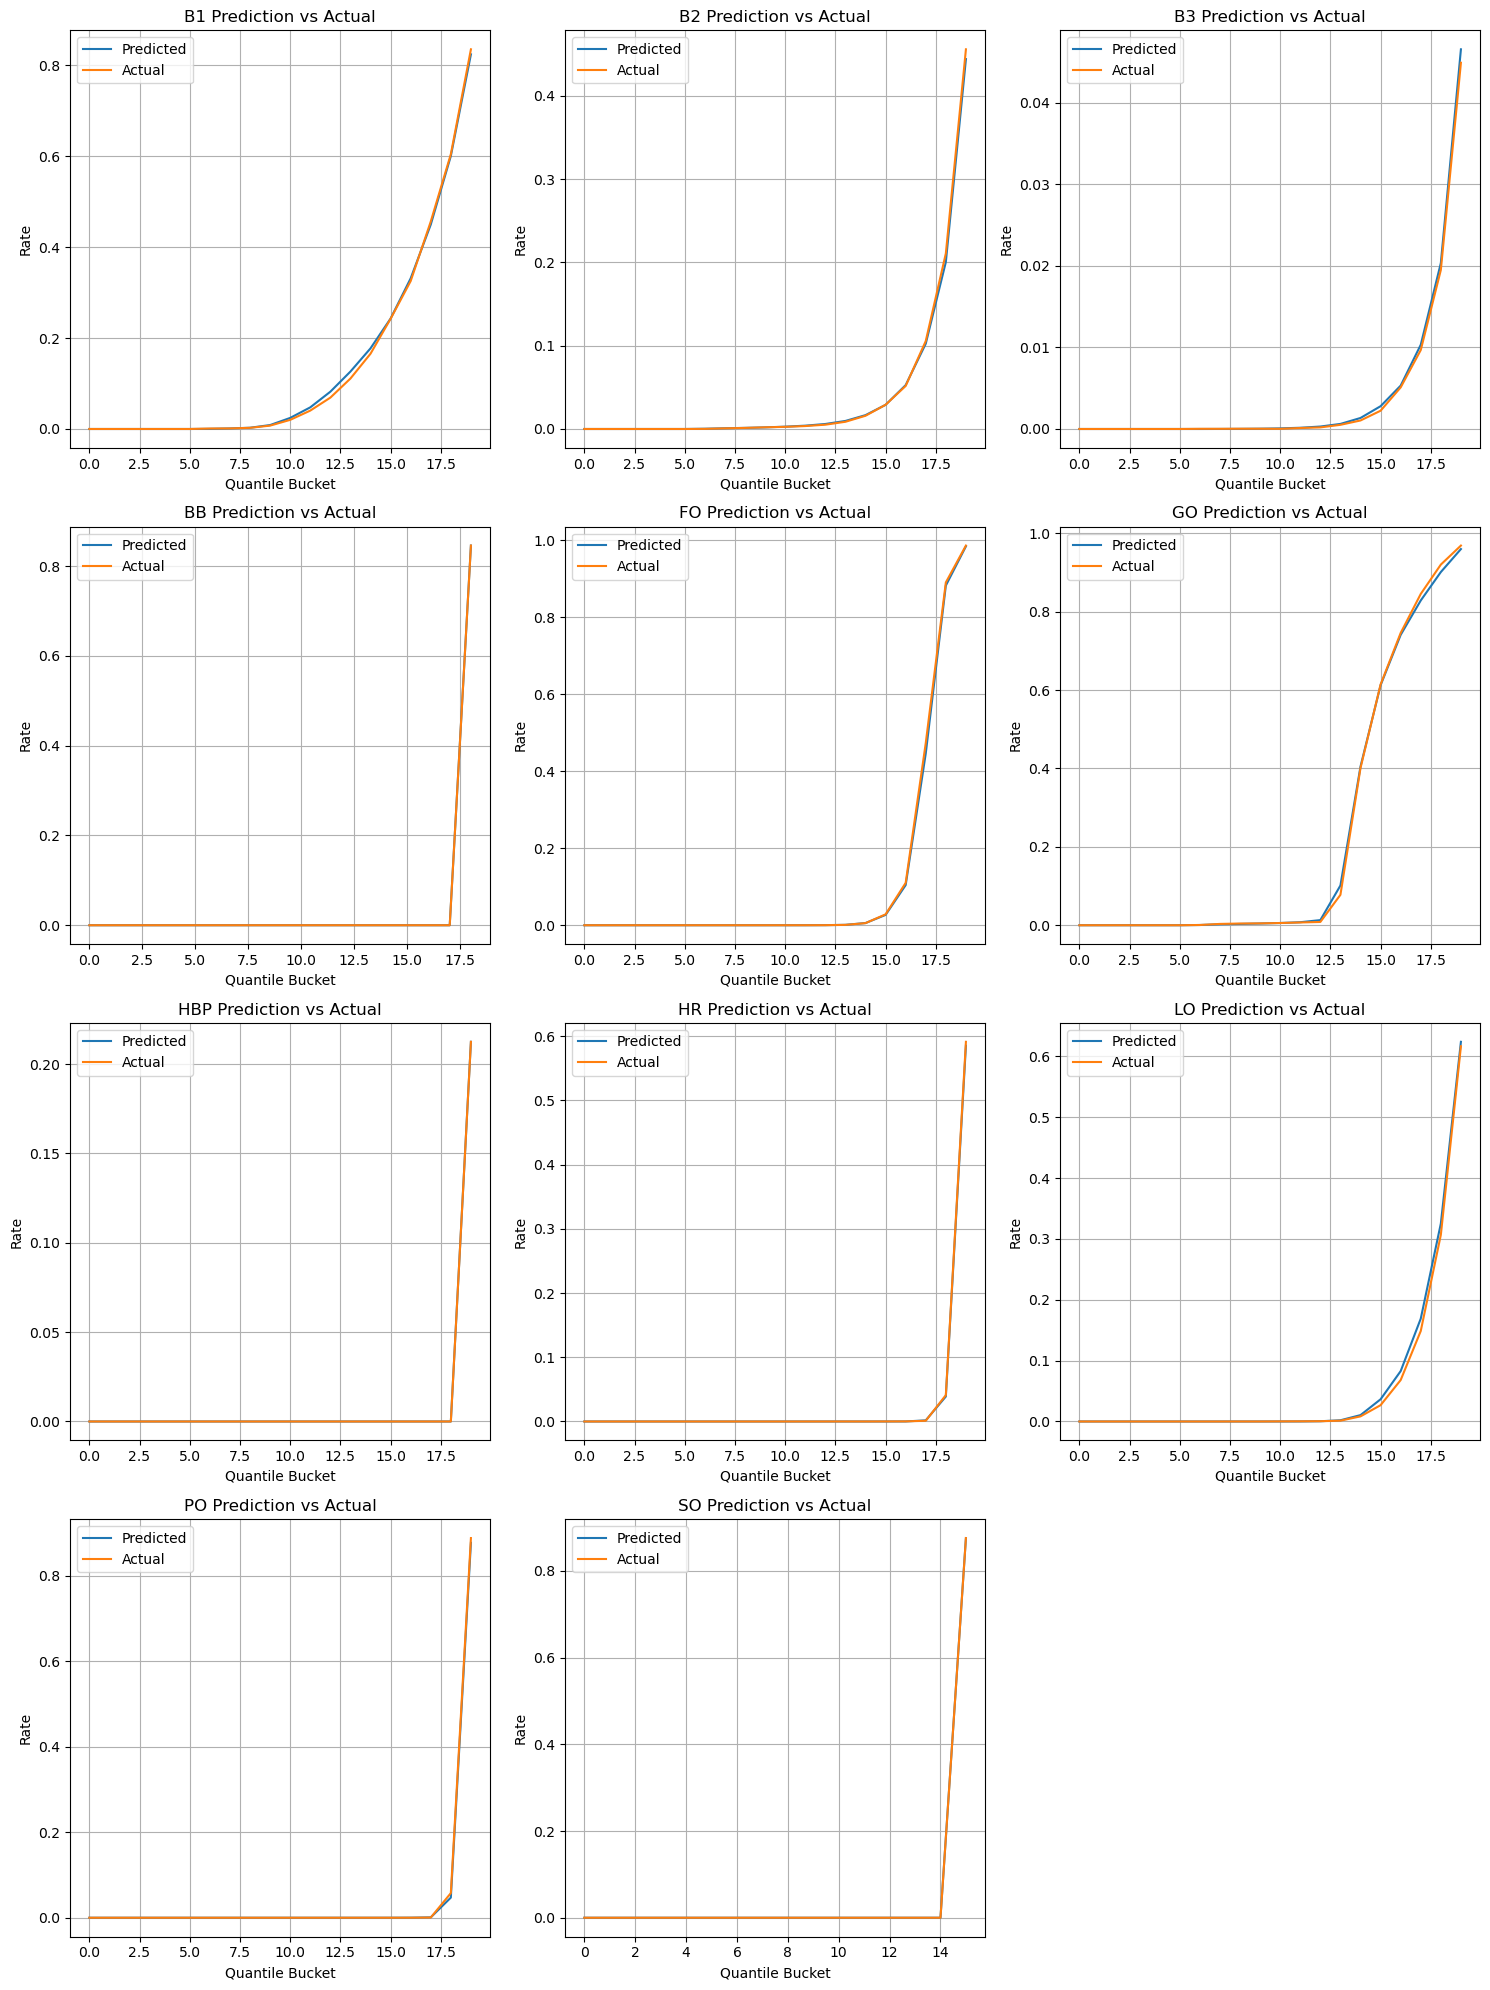

In [26]:
# Adjust the number of rows and columns
n_events = len(events_list)
n_cols = 3
n_rows = (n_events + n_cols - 1) // n_cols  # Ceiling division

# Set square plots: each subplot is 5x5 inches
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, event in enumerate(events_list):
    ax = axes[i]
    pred_col = f"{event}_pred_batted"
    
    if pred_col not in prediction_df.columns:
        continue

    # Bucket the predicted values into quantiles
    prediction_df['bucket'] = pd.qcut(prediction_df[pred_col], q=20, duplicates='drop')

    # Compute averages
    bucket_avg = prediction_df.groupby('bucket').agg(
        avg_pred=(pred_col, 'mean'),
        avg_actual=(event, 'mean')
    ).reset_index()

    # Plot
    ax.plot(bucket_avg['avg_pred'], label='Predicted')
    ax.plot(bucket_avg['avg_actual'], label='Actual')
    ax.set_title(f"{event.upper()} Prediction vs Actual")
    ax.set_xlabel("Quantile Bucket")
    ax.set_ylabel("Rate")
    ax.legend()
    ax.grid(True)

# Remove extra axes if any
for j in range(n_events, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Calculate PFX

In [27]:
events_list_pred_batted = [f"{event}_pred_batted" for event in events_list]
pfx_list = [f"{event}_pfx" for event in events_list]

In [28]:
game_pfx_df = prediction_df.groupby(['venue_id', 'gamePk', 'batSide', 'date'])[events_list + events_list_pred_batted].mean().reset_index()

In [29]:
num_games = 243

In [30]:
# Make sure the data is sorted appropriately for rolling
game_pfx_df = game_pfx_df.sort_values(['venue_id', 'date', 'batSide'])

In [31]:
game_pfx_df.head()

,venue_id,gamePk,batSide,date,b1,b2,b3,bb,fo,go,hbp,hr,lo,po,so,b1_pred_batted,b2_pred_batted,b3_pred_batted,bb_pred_batted,fo_pred_batted,go_pred_batted,hbp_pred_batted,hr_pred_batted,lo_pred_batted,po_pred_batted,so_pred_batted
0,1,413700,L,20150410,0.090909,0.090909,0.000000,0.045455,0.045455,0.272727,0.136364,0.000000,0.045455,0.090909,0.181818,0.127394,0.025778,0.004788,0.045455,0.106780,0.278358,0.136364,0.003678,0.035322,0.054264,0.181818
1,1,413700,R,20150410,0.166667,0.018519,0.000000,0.055556,0.074074,0.240741,0.000000,0.037037,0.092593,0.111111,0.203704,0.167637,0.030506,0.003344,0.055556,0.096929,0.242771,0.000000,0.022898,0.083726,0.092930,0.203704
2,1,413715,L,20150411,0.121212,0.060606,0.000000,0.121212,0.030303,0.181818,0.060606,0.060606,0.090909,0.060606,0.212121,0.142693,0.027432,0.005804,0.121212,0.071949,0.181974,0.060606,0.033163,0.083532,0.059513,0.212121
3,1,413715,R,20150411,0.214286,0.000000,0.000000,0.023810,0.142857,0.261905,0.000000,0.023810,0.119048,0.119048,0.095238,0.184443,0.043291,0.003191,0.023810,0.152023,0.293656,0.000000,0.014778,0.084679,0.104890,0.095238
4,1,413730,L,20150412,0.100000,0.000000,0.000000,0.000000,0.100000,0.100000,0.050000,0.000000,0.100000,0.150000,0.400000,0.097616,0.018941,0.003571,0.000000,0.142328,0.119012,0.050000,0.003096,0.033776,0.131661,0.400000


##### Unshifted

In [32]:
# Compute the rolling average of the last num_games *including* the current row
rolling_avgs = (
    game_pfx_df
    .groupby(['venue_id', 'batSide'], group_keys=False)
    .apply(lambda group: group[events_list + events_list_pred_batted].shift(0).rolling(num_games, min_periods=1).mean())
)

# Rename columns to indicate they are rolling averages
rolling_avgs.columns = [f'{col}_rolling' for col in events_list + events_list_pred_batted]

# Concatenate with the original dataframe
unshifted_game_pfx_df = pd.concat([game_pfx_df, rolling_avgs], axis=1)

for event in events_list:
    unshifted_game_pfx_df[f'{event}_pfx'] = unshifted_game_pfx_df[f'{event}_rolling'] / unshifted_game_pfx_df[f'{event}_pred_batted_rolling']

In [33]:
unshifted_game_pfx_df[['venue_id', 'batSide'] + [col for col in unshifted_game_pfx_df if col.endswith("pfx")]].drop_duplicates(subset=['venue_id', 'batSide'], keep='last').to_csv(os.path.join(baseball_path, "Park Latest.csv"), index=False)

##### Shifted

In [34]:
# Compute the rolling average of the last num_games *excluding* the current row
rolling_avgs = (
    game_pfx_df
    .groupby(['venue_id', 'batSide'], group_keys=False)
    .apply(lambda group: group[events_list + events_list_pred_batted].shift(1).rolling(num_games, min_periods=1).mean())
)

# Rename columns to indicate they are rolling averages
rolling_avgs.columns = [f'{col}_rolling' for col in events_list + events_list_pred_batted]

# Concatenate with the original dataframe
shifted_game_pfx_df = pd.concat([game_pfx_df, rolling_avgs], axis=1)

for event in events_list:
    shifted_game_pfx_df[f'{event}_pfx'] = shifted_game_pfx_df[f'{event}_rolling'] / shifted_game_pfx_df[f'{event}_pred_batted_rolling']

### Model #2. Weather Factors

$ \hat{\text{eventsModel2}} = \hat{\text{eventsModel}} + pfx + meteo\_x\_vect + meteo\_y\_vect + temperature\_2m + relative\_humidity\_2m + dew\_point\_2m + surface\_pressure + venue\_id $

The purpose of this model is to estimate rates of events in games based on weather and venue. This model is trained with expected rates based on the actual batted ball data. This allows for us to control for differences in inherent batted ball data across games. The model then predicts with league average rates to determine how a game with typical batted ball data would differ in various weather and venue conditions. <br>
Ideally, we would then compare these predicted rates to league average rates to determine park x weather factors, multipliers that estimate how much more or less likely given events are on the game-level than under average conditions. <br>
However, this is hard. <br>
Instead, predicted rates are used to assign park-specific quantiles to games based on weather conditions. For instance, a weather conditions that predict a 0.05 projected home run rate at Fenway may get a game assigned to the top quantile of games at that park. From this point, multipliers will be calculated by averaging actual home runs rates at similar games and dividing by batted-ball predicted home run rates at those same games. The result can be interpreted as a multiplier that determines how much more or less likely were home runs at games with similar weather conditions compared to their batted ball likelihoods.

##### Inputs

Meteo weather inputs

In [35]:
meteo_weather_list = ['meteo_x_vect', 'meteo_y_vect', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure']

Parks with sufficient samples

In [36]:
venue_dummy_list = [f'venue_{id}' for id in sorted(prediction_df['venue_id'].value_counts()[lambda x: x > 20000].index.tolist())]

Select inputs

In [37]:
wfx_inputs = events_list_pred_batted + pfx_list + meteo_weather_list + venue_dummy_list + ['b_L']

##### Sample

Merge in park factors

In [38]:
sample_df2 = prediction_df.merge(shifted_game_pfx_df[['gamePk', 'batSide'] + pfx_list], on=['gamePk', 'batSide'], how='left')

Create venue dummies

Note: not all venue dummies may be included in venue_dummy_list

In [39]:
sample_df2['venue_id2'] = sample_df2['venue_id'].copy()

In [40]:
sample_df2 = pd.get_dummies(sample_df2, columns=['venue_id2'], prefix='venue', drop_first=False)

Set pfx to 1 if not in venue sample

Note: we may want to set this in shifted_game_pfx_df and default to a rolling value

In [41]:
sample_df2['sample_venue'] = sample_df2[venue_dummy_list].sum(axis=1)

In [42]:
for pfx in pfx_list:
    sample_df2[pfx] = np.where(sample_df2['sample_venue'] == 0, 1, sample_df2[pfx])

Drop if missing inputs

In [43]:
sample_df2.dropna(subset=wfx_inputs, inplace=True)

Group by game

In [44]:
sample_df2 = sample_df2.groupby(['gamePk', 'date', 'venue_id', 'batSide'])[wfx_inputs + events_list].mean().reset_index()

In [45]:
sample_df2['b_L'] = (sample_df2['batSide'] == "L").astype(int)

In [46]:
sample_df2 = sample_df2[sample_df2['date'] > 20180101]

In [47]:
# Split features and target
X = sample_df2[wfx_inputs].values
y = sample_df2[events_list].values

# Number of classes
num_classes = y.shape[1]

###### Scale

In [48]:
if not hasattr(sys.modules['__main__'], '__file__'):
    # Scale
    scale_wfx = StandardScaler()
    # Fit and transform
    X_scaled = scale_wfx.fit_transform(X)
    # Create directory
    os.makedirs(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate), exist_ok=True)
    # Save
    pickle.dump(scale_wfx, open(os.path.join(model_path, "M01. Park and Weather Factors", todaysdate, "scale_wfx.pkl"), 'wb'))
else:
    X_scaled = scale_wfx.transform(X)

##### Train

In [49]:
%%time
if not hasattr(sys.modules['__main__'], '__file__'):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import BatchNormalization, Dropout
    from tensorflow.keras.losses import KLDivergence

    class VotingEnsemble:
        def __init__(self, models):
            self.models = models

        def predict(self, X):
            predictions = np.array([model.predict(X, verbose=0) for model in self.models])
            return np.mean(predictions, axis=0)

    ensemble_size = 5
    ensemble_models = []
    model_dir = os.path.join(model_path, "M01. Park and Weather Factors", todaysdate)
    os.makedirs(model_dir, exist_ok=True)

    for i in range(ensemble_size):
        model = Sequential([
            Dense(128, input_shape=(X_scaled.shape[1],), activation='relu'),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(128, activation='relu'),
            # Dropout(0.3),
            Dense(64, activation='relu'),
            # Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      # loss='categorical_crossentropy',
                      loss=keras.losses.KLDivergence(),
                      metrics=[KLDivergence()])

        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        model.fit(
            X_scaled, y,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

        # Create folder
        model_path_i = os.path.join(model_dir, f'predict_wfx_{i}.keras')
        model.save(model_path_i)
        ensemble_models.append(model)

    # Wrap ensemble in predict_wfx for compatibility
    predict_wfx = VotingEnsemble(ensemble_models)

Epoch 1/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - kl_divergence: 0.1659 - loss: 0.1659 - val_kl_divergence: 0.0717 - val_loss: 0.0718
Epoch 2/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0834 - loss: 0.0834 - val_kl_divergence: 0.0670 - val_loss: 0.0671
Epoch 3/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0754 - loss: 0.0754 - val_kl_divergence: 0.0651 - val_loss: 0.0652
Epoch 4/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0722 - loss: 0.0722 - val_kl_divergence: 0.0630 - val_loss: 0.0631
Epoch 5/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0708 - loss: 0.0708 - val_kl_divergence: 0.0616 - val_loss: 0.0617
Epoch 6/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0691 - loss: 0.0691 - val_kl_divergence: 0.0609 - val_loss: 0.0610
Epoch 7/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_divergence: 0.0688 - loss: 0.0688 - val_kl_divergence: 0.0620 - val_loss: 0.0621
Epoch 8/100
801/801 ━━━━━━━

##### Predict

Save event averages for use in predictions in A06. Weather

In [50]:
average_df = pd.DataFrame(sample_df2[events_list].mean()).T
# average_df.to_csv(os.path.join(baseball_path, "Event Averages.csv"), index=False)

Before predicting, replace with mean predicted event rates (based on batted ball data) to determine how weather would affect an average batted-ball game

In [51]:
sample_df3 = sample_df2.copy()
for event in events_list:
    sample_df3[f'{event}_pred_batted'] = sample_df3[event].mean()

Now actually predict

In [52]:
# Split features and target
X2 = sample_df3[wfx_inputs].values
y2 = sample_df3[events_list].values

# Scale the features
X2_scaled = scale_wfx.transform(X2)

In [53]:
predictions2 = predict_wfx.predict(X2_scaled)
prediction_df2 = pd.DataFrame(predictions2, columns=events_list)

prediction_df2 = prediction_df2.add_suffix('_pred_weather')

prediction_df2 = pd.concat([prediction_df2, sample_df3.reset_index()], axis=1)

In [54]:
prediction_df2.head()

,b1_pred_weather,b2_pred_weather,b3_pred_weather,bb_pred_weather,fo_pred_weather,go_pred_weather,hbp_pred_weather,hr_pred_weather,lo_pred_weather,po_pred_weather,so_pred_weather,index,gamePk,date,venue_id,batSide,b1_pred_batted,b2_pred_batted,b3_pred_batted,bb_pred_batted,fo_pred_batted,go_pred_batted,hbp_pred_batted,hr_pred_batted,lo_pred_batted,po_pred_batted,so_pred_batted,b1_pfx,b2_pfx,b3_pfx,bb_pfx,fo_pfx,go_pfx,hbp_pfx,hr_pfx,lo_pfx,po_pfx,so_pfx,meteo_x_vect,meteo_y_vect,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2602,venue_2680,venue_2681,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5325,b_L,b1,b2,b3,bb,fo,go,hbp,hr,lo,po,so
0,0.143625,0.046206,0.003071,0.082553,0.121608,0.224675,0.013168,0.035719,0.052260,0.049972,0.227143,13704,529406,20180329,12,L,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,0.995572,0.988872,0.842182,1.000000,1.024243,0.965431,0.999986,1.132422,0.960591,1.115591,1.000000,0.000000,0.000000,70.000000,60.000000,57.000000,1015.421450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.045455,0.045455,0.136364,0.045455,0.409091,0.000000,0.000000,0.090909,0.136364,0.090909
1,0.144154,0.046478,0.002964,0.080784,0.121695,0.223560,0.012657,0.034773,0.054013,0.048795,0.230128,13705,529406,20180329,12,R,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,1.033997,0.973217,0.806200,1.000000,1.047200,0.954837,1.000002,1.103302,0.882146,1.101218,1.000000,0.000000,0.000000,70.000000,60.000000,57.000000,1015.421450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.104167,0.083333,0.000000,0.125000,0.062500,0.187500,0.000000,0.020833,0.062500,0.041667,0.312500
2,0.141260,0.040268,0.002783,0.088273,0.128773,0.226801,0.013981,0.028388,0.055364,0.049027,0.225083,13706,529407,20180329,4169,L,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,1.059416,0.886489,1.336281,1.000000,1.032553,0.961619,0.999995,0.966228,1.022356,0.996662,1.000000,-2.897322,-11.915601,76.686800,55.543697,59.586800,1020.982900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1,0.033333,0.066667,0.033333,0.100000,0.100000,0.166667,0.066667,0.100000,0.033333,0.100000,0.200000
3,0.143759,0.042552,0.002782,0.088532,0.126363,0.223583,0.014576,0.028211,0.054186,0.048185,0.227270,13707,529407,20180329,4169,R,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,0.966745,1.079802,1.273975,1.000000,1.029731,0.971185,1.000001,0.995662,1.036338,1.049629,1.000000,-2.897322,-11.915601,76.686800,55.543697,59.586800,1020.982900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.122449,0.081633,0.000000,0.163265,0.081633,0.163265,0.040816,0.000000,0.061224,0.081633,0.204082
4,0.152380,0.046263,0.003375,0.089693

Calculate WFX

Predicted, based on weather, over predicted, based on batted-ball data

In [55]:
for event in events_list:
    prediction_df2[f'{event}_wfx_unadj'] = prediction_df2[f'{event}_pred_weather'] / prediction_df2[f'{event}_pred_batted']

Highlight outliers

In [56]:
# Sort and get top/bottom 500
top_500 = prediction_df2.nlargest(500, 'hr_wfx_unadj')
bottom_500 = prediction_df2.nsmallest(500, 'hr_wfx_unadj')

# Get value counts
top_counts = top_500['venue_id'].value_counts().head(5)
bottom_counts = bottom_500['venue_id'].value_counts().head(5)

# Combine into a 5x4 DataFrame
result_df = pd.DataFrame({
    'Top Venue': top_counts.index,
    'Top Count': top_counts.values,
    'Bottom Venue': bottom_counts.index,
    'Bottom Count': bottom_counts.values
})

result_df

,Top Venue,Top Count,Bottom Venue,Bottom Count
0,19,238,7,227
1,2602,124,17,106
2,17,78,2394,63
3,32,24,3,47
4,22,11,3312,13


In [57]:
prediction_df2.sort_values('hr_wfx_unadj', ascending=False).head(100)[['meteo_y_vect', 'temperature_2m']].mean()

meteo_y_vect      6.834281
temperature_2m   86.881019
dtype: float64

In [58]:
prediction_df2.sort_values('hr_wfx_unadj', ascending=False).tail(100)[['meteo_y_vect', 'temperature_2m']].mean()

meteo_y_vect     -6.931046
temperature_2m   52.380815
dtype: float64

##### Plot

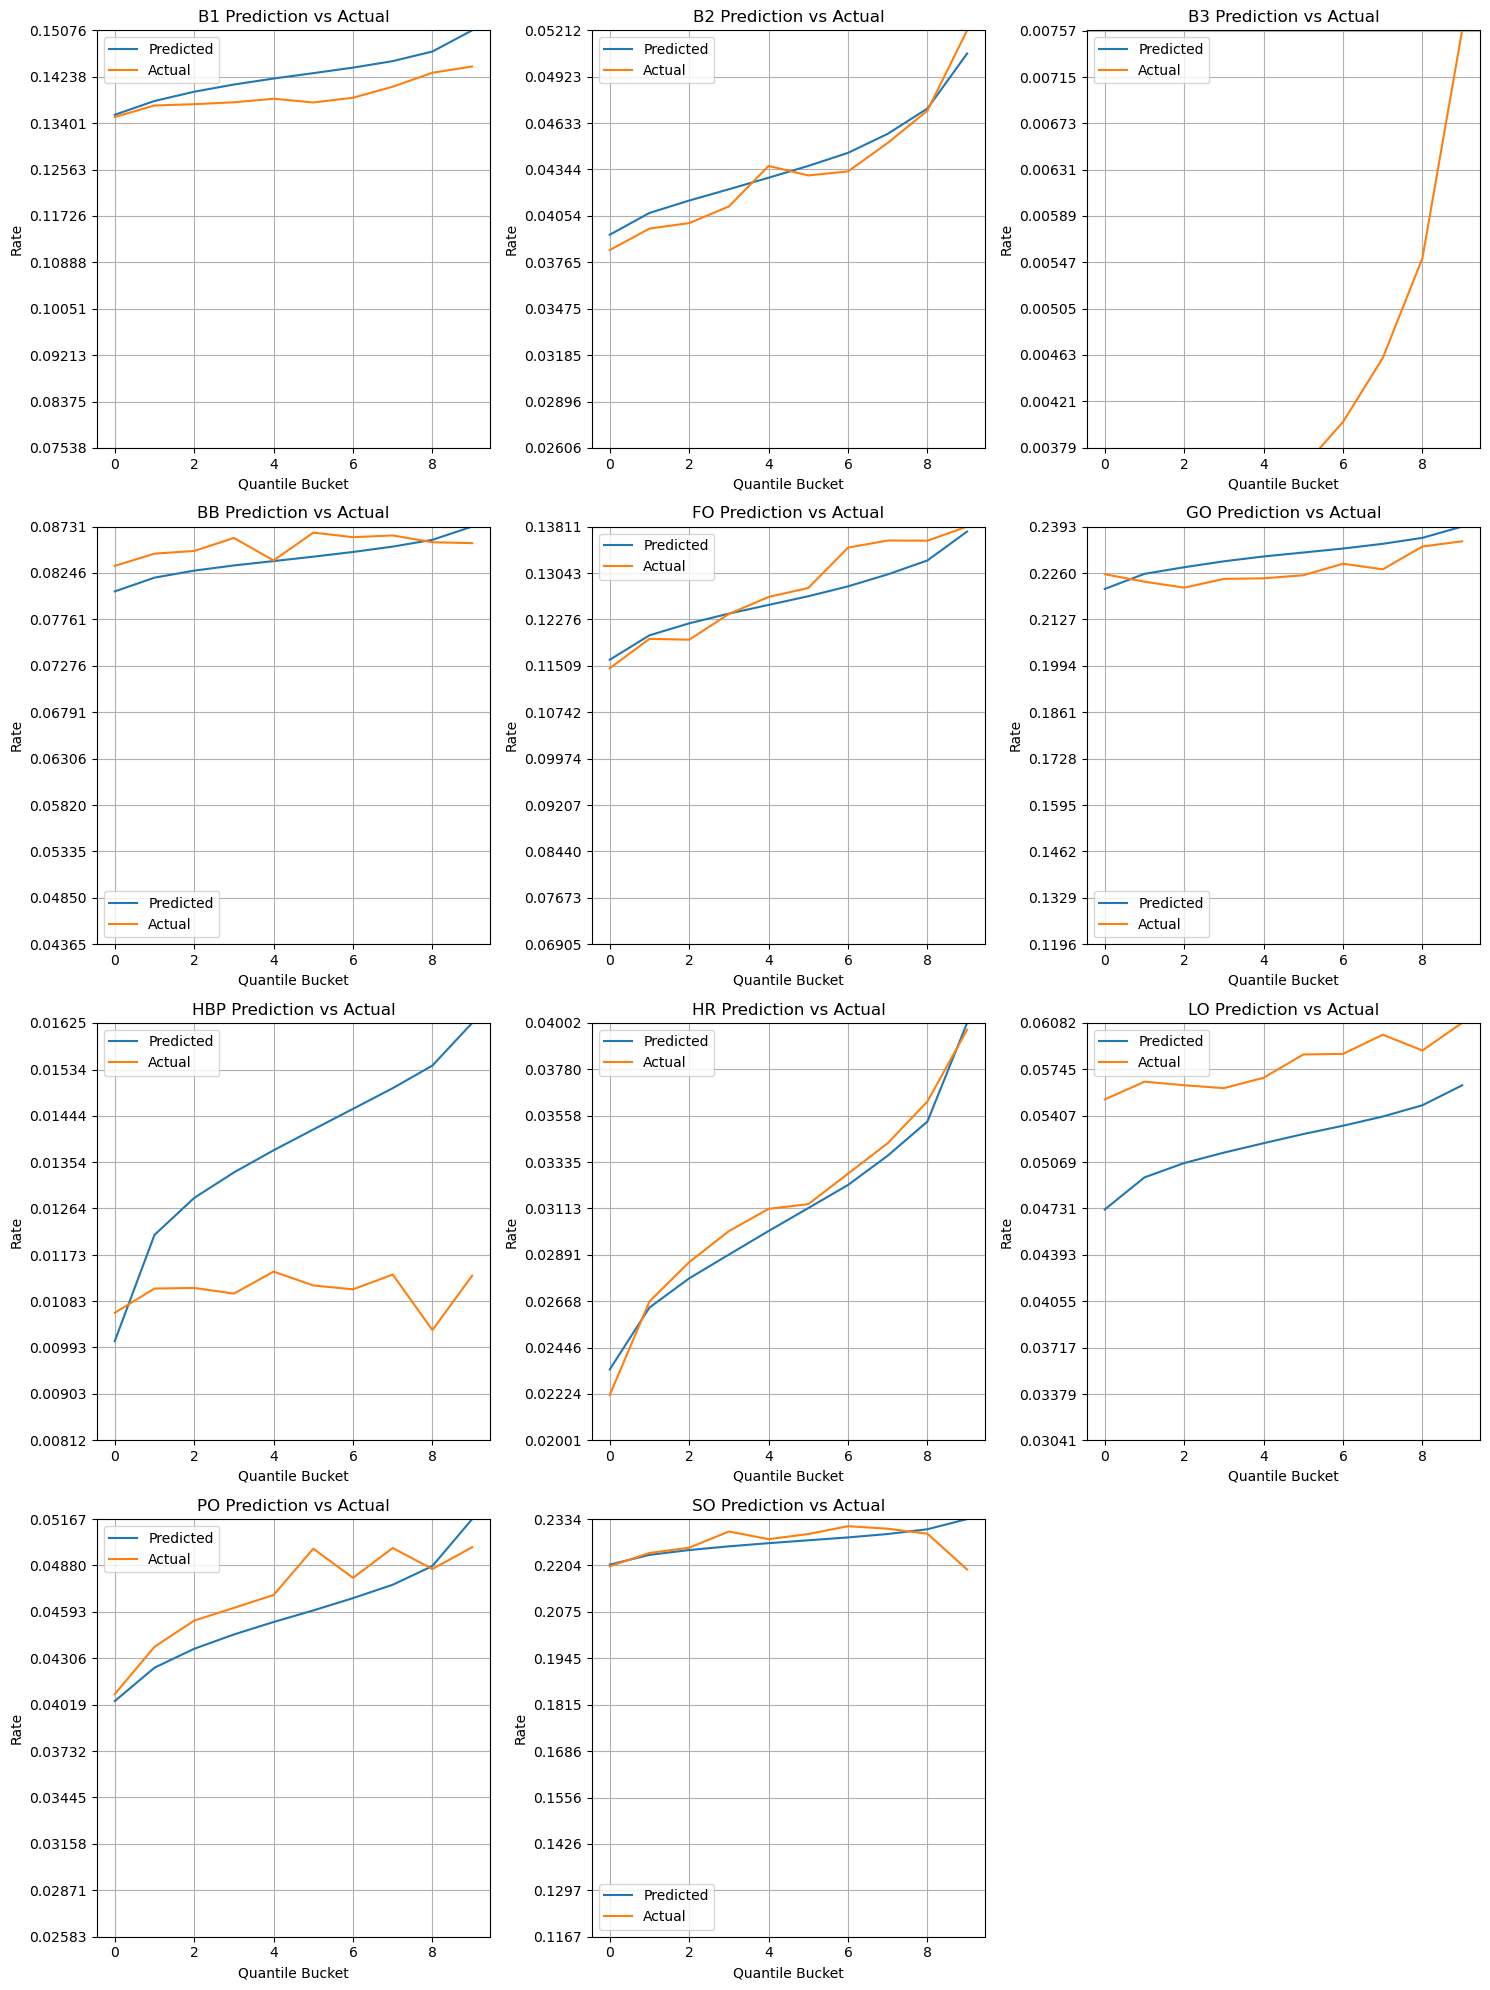

In [59]:
# Adjust the number of rows and columns
n_events = len(events_list)
n_cols = 3
n_rows = (n_events + n_cols - 1) // n_cols  # Ceiling division

# Set square plots: each subplot is 5x5 inches
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, event in enumerate(events_list):
    ax = axes[i]
    pred_col = f"{event}_pred_weather"
    
    if pred_col not in prediction_df2.columns:
        continue

    # Bucket the predicted values into quantiles
    prediction_df2['bucket'] = pd.qcut(prediction_df2[pred_col], q=10, duplicates='drop')

    # Compute averages
    bucket_avg = prediction_df2.groupby('bucket').agg(
        avg_pred=(pred_col, 'mean'),
        avg_actual=(event, 'mean')
    ).reset_index()

    # Plot
    ax.plot(bucket_avg['avg_pred'], label='Predicted')
    ax.plot(bucket_avg['avg_actual'], label='Actual')
    ax.set_title(f"{event.upper()} Prediction vs Actual")
    ax.set_xlabel("Quantile Bucket")
    ax.set_ylabel("Rate")
    ax.legend()
    ax.grid(True)

    # Set y-axis limits: from 1/3 of the max to the max
    y_max = max(bucket_avg['avg_pred'].max(), bucket_avg['avg_actual'].max())
    y_min = y_max / 2

    # Create 10 evenly spaced ticks from y_min to y_max
    ticks = np.linspace(y_min, y_max, 10)
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.round(ticks, 5))  # round for cleaner labels

# Remove extra axes if any
for j in range(n_events, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Drop bucket column 

In [60]:
prediction_df2.drop(columns={'bucket'}, inplace=True)

##### Calibrate

In [61]:
%%time
n = 50  # number of last past games to consider (your desired threshold)

# Convert pandas DataFrame to Polars DataFrame
# IMPORTANT: Ensure prediction_df2 is sorted by your game time column (e.g., 'gamePk', 'date')
# BEFORE this cell if it's not already. For example:
# prediction_df2 = prediction_df2.sort_values(by='gamePk').copy()
df = pl.from_pandas(prediction_df2.copy())

# Initialize lists to store results for new columns
results_mean = {f'{event}_mean': [] for event in events_list}
results_pred_batted_mean = {f'{event}_pred_batted_mean': [] for event in events_list}

# Iterate through each row of the Polars DataFrame
for i in range(len(df)):
    current_row = df.row(i, named=True)  # Get the current row data as a dictionary
    past_data = df.slice(0, i) # Get all data from previous rows in the DataFrame (already chronological)

    # Process for each event type
    for event in events_list:
        true_col = event            # Column for '{event}_mean' (your actual event result)
        model_col = f'{event}_pred_batted' # Column for '{event}_pred_mean' (your model's event prediction)

        # --- Step 1: Attempt strict filtering (venue_id AND batSide) ---
        past_subset_strict_filter = past_data.filter(
            (pl.col('venue_id') == current_row['venue_id']) &
            (pl.col('batSide') == current_row['batSide'])
        )

        games_to_average = None # Initialize variable to hold the final set of games

        # --- Step 2: Check count and apply conditional logic ---
        if len(past_subset_strict_filter) < n:
            # If strict filter yields less than 'n' games, fallback to broader filter
            # print(f"Row {i}, Event {event}: Less than {n} games with strict filter ({len(past_subset_strict_filter)} found). Falling back to batSide only.")
            past_subset_broad_filter = past_data.filter(
                pl.col('batSide') == current_row['batSide']
            )
            games_to_average = past_subset_broad_filter
        else:
            # If strict filter yields 'n' or more games, use those
            games_to_average = past_subset_strict_filter

        # --- Handle cases where even the broadest filter yields no games ---
        if games_to_average.is_empty():
            results_mean[f'{event}_mean'].append(np.nan)
            results_pred_batted_mean[f'{event}_pred_batted_mean'].append(np.nan)
            continue

        # --- Step 3: Take the last 'n' games from the chosen subset and average ---
        final_games_for_avg = games_to_average.tail(n)

        # Compute the mean of the relevant columns
        results_mean[f'{event}_mean'].append(final_games_for_avg[true_col].mean())
        results_pred_batted_mean[f'{event}_pred_batted_mean'].append(final_games_for_avg[model_col].mean())

# Combine all collected results into a single dictionary
final_results_combined = {}
final_results_combined.update(results_mean)
final_results_combined.update(results_pred_batted_mean)

# Add the newly computed columns to the Polars DataFrame
for col_name, values_list in final_results_combined.items():
    df = df.with_columns(pl.Series(name=col_name, values=values_list))

# Convert the final Polars DataFrame back to a pandas DataFrame
prediction_df2 = df.to_pandas()

CPU times: total: 33min 40s
Wall time: 6min 35s


In [62]:
prediction_df2.tail()

,b1_pred_weather,b2_pred_weather,b3_pred_weather,bb_pred_weather,fo_pred_weather,go_pred_weather,hbp_pred_weather,hr_pred_weather,lo_pred_weather,po_pred_weather,so_pred_weather,index,gamePk,date,venue_id,batSide,b1_pred_batted,b2_pred_batted,b3_pred_batted,bb_pred_batted,fo_pred_batted,go_pred_batted,hbp_pred_batted,hr_pred_batted,lo_pred_batted,po_pred_batted,so_pred_batted,b1_pfx,b2_pfx,b3_pfx,bb_pfx,fo_pfx,go_pfx,hbp_pfx,hr_pfx,lo_pfx,po_pfx,so_pfx,meteo_x_vect,meteo_y_vect,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2602,venue_2680,venue_2681,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5325,b_L,b1,b2,b3,bb,fo,go,hbp,hr,lo,po,so,b1_wfx_unadj,b2_wfx_unadj,b3_wfx_unadj,bb_wfx_unadj,fo_wfx_unadj,go_wfx_unadj,hbp_wfx_unadj,hr_wfx_unadj,lo_wfx_unadj,po_wfx_unadj,so_wfx_unadj,b1_mean,b2_mean,b3_mean,bb_mean,fo_mean,go_mean,hbp_mean,hr_mean,lo_mean,po_mean,so_mean,b1_pred_batted_mean,b2_pred_batted_mean,b3_pred_batted_mean,bb_pred_batted_mean,fo_pred_batted_mean,go_pred_batted_mean,hbp_pred_batted_mean,hr_pred_batted_mean,lo_pred_batted_mean,po_pred_batted_mean,so_pred_batted_mean
32023,0.144901,0.041046,0.002708,0.083676,0.135292,0.225341,0.012796,0.027765,0.051768,0.044051,0.230656,45727,778562,20250327,4169,R,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,0.986073,1.063427,0.913685,1.000000,1.070495,1.025021,1.000001,0.810684,0.854359,1.008181,1.000000,11.323444,-5.772936,78.576800,49.402695,58.056800,1021.683170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.090909,0.045455,0.022727,0.136364,0.022727,0.204545,0.068182,0.022727,0.068182,0.090909,0.227273,1.042311,0.946243,0.673129,0.981132,1.060233,0.992995,1.160100,0.887303,0.896194,0.938442,1.017306,0.152272,0.051607,0.003245,0.076217,0.130253,0.249262,0.010165,0.019858,0.056475,0.041433,0.209214,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732
32024,0.146941,0.045871,0.002755,0.084552,0.123359,0.225786,0.015647,0.031601,0.054900,0.044679,0.223910,45728,778563,20250318,2397,L,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,70.000000,60.000000,57.000000,1011.538300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.096774,0.064516,0.000000,0.096774,0.096774,0.290323,0.000000,0.000000,0.096774,0.032258,0.225806,1.056981,1.057476,0.684904,0.991404,0.966720,0.994958,1.418499,1.009885,0.950415,0.951806,0.987553,0.132681,0.037814,0.003417,0.098905,0.131574,0.218923,0.006833,0.031426,0.053233,0.044864,0.240331,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732
32025,0.146668,0.045950,0.002743,0.084595,0.123540,0.226511,0.015477,0.031147,0.054450,0.044885,0.224034,45729,778563,20250318,2397,R,0.139019,0.043378,0.004023,0.085285,0.127606,0.226931,0.011030,0.031291,0.057764,0.046941,0.226732,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,70.000000,60.000000,57.000000,1011.538300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

##### Calculate WFX

WFX = Actual for similar games / Predicted (using batted-ball data) in similar games 

In [63]:
for event in events_list:
    prediction_df2[f'{event}_wfx_adj'] = prediction_df2[f'{event}_mean'] / prediction_df2[f'{event}_pred_batted_mean']

##### Evaluate

What questions are you trying to answer?
    - Do multipliers predict hr rates?
    - Are multipliers "fair" across venue and hand?

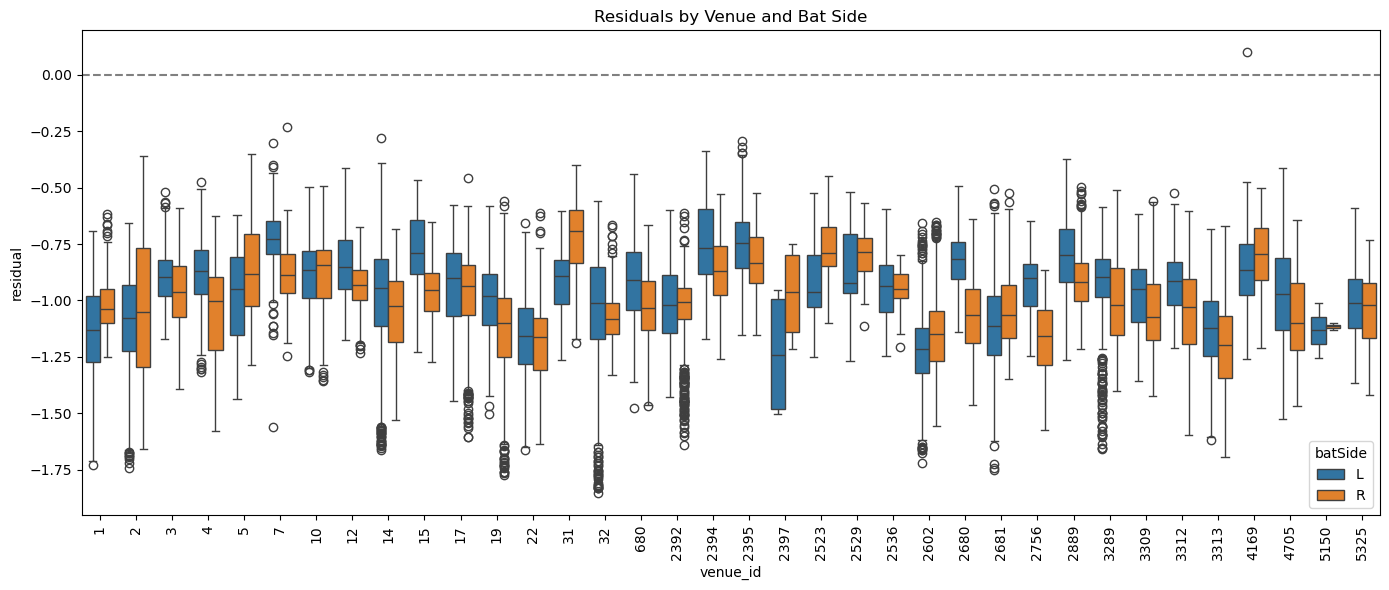

In [64]:
prediction_df2['residual'] = prediction_df2['hr'] - prediction_df2['hr_wfx_adj']


plt.figure(figsize=(14, 6))
sns.boxplot(x='venue_id', y='residual', hue='batSide', data=prediction_df2)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.title("Residuals by Venue and Bat Side")
plt.tight_layout()
plt.show()


##### WFX Dataframe

Convert from long to wide

In [65]:
l_shifted_game_wfx_df = prediction_df2[prediction_df2['batSide'] == "L"]
r_shifted_game_wfx_df = prediction_df2[prediction_df2['batSide'] == "R"]

wfx_df = pd.merge(l_shifted_game_wfx_df, r_shifted_game_wfx_df, on=['venue_id', 'gamePk', 'date'], how='left', suffixes=("_l", "_r"))

Write all game WFX to CSV

In [66]:
wfx_df[['venue_id', 'gamePk', 'date'] + [col for col in wfx_df if "wfx" in col] + [col for col in wfx_df if "pred" in col] + [f'{event}_l' for event in events_list] + [f'{event}_r' for event in events_list]].to_csv(os.path.join(baseball_path, "Park and Weather Factors.csv"), index=False)

Write individual-game WFX to CSV

In [67]:
for date in wfx_df['date'].unique():
    wfx_df[wfx_df['date'] == date][['venue_id', 'gamePk', 'date'] + [col for col in wfx_df if "wfx" in col]].to_csv(os.path.join(baseball_path, "A06. Weather", "3. Park and Weather Factors", f"Park and Weather Factors {date}.csv"), index=False)

##### Player Stat DataFrame

This comes from Model #1 and is completely independent of Model #2. Placement is for convenience, not necessarily logic.

Replace actual event rates with predicted ones

In [68]:
prediction_df[events_list] = prediction_df[events_list_pred_batted].copy()

Drop unneeded columns

In [69]:
if 'bucket' in list(prediction_df.columns):
    prediction_df.drop(columns=['bucket'], inplace=True)

Calculate rolling stats

In [70]:
short, long = 50, 300

Short

In [71]:
start_time = time.time()
df_short = rolling_pas(prediction_df, short, events_list)
print(f"Short took {time.time() - start_time:.2f} seconds")

Short took 15.95 seconds


Long

In [72]:
start_time = time.time()
df_long = rolling_pas(prediction_df, long, events_list)
df_long = df_long.add_suffix("_long")
print(f"Long took {time.time() - start_time:.2f} seconds")

# We only need the rolling stats from long (the rest are in df_short)
long_stats = batter_stats_long + pitcher_stats_long
df_long = df_long[long_stats]

Long took 24.98 seconds


Merge long stats onto rolling (and other) stats

In [73]:
final_dataset = pd.concat([df_short, df_long], axis=1)
final_dataset.reset_index(drop=True, inplace=True)
final_dataset.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)
final_dataset.drop(columns=events_list + ['Cut'], inplace=True)

Add event dummies

In [74]:
event_dummies = pd.get_dummies(final_dataset['eventsModel']).astype(int)

In [75]:
final_dataset = pd.concat([final_dataset, event_dummies], axis=1)

Clean

In [76]:
final_dataset = final_dataset.replace([float('inf'), float('-inf')], 0)

Write to CSV

In [77]:
%%time
final_dataset.to_csv(os.path.join(baseball_path, "Final Dataset.csv"), index=False)

CPU times: total: 5min 12s
Wall time: 5min 14s


In [78]:
final_dataset['date'].max()

20250906

### Required Follow-Ups:
- Model #1. Expected Outcomes
    - Model #2. Expected Outcomes
    - B01. Matchups
    - M02. Stat Imputations
    - M03. Plate Appearances
- Model #2. Park and Weather Factors
    - M03. Plate Appearances

Note: You should avoid rerunning Model #1. Expected Outcomes as much as possible. Likely shouldn't need many updates anyway.